In [1]:
import time
import glob
import os
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')
print(f'matplotlib: {matplotlib.__version__}')
print(f'seaborn: {sns.__version__}')

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', str)

pandas: 2.1.1
numpy: 1.26.0
matplotlib: 3.8.0
seaborn: 0.13.0


# Load Zoopla Data

Zoopla dataset is extremely large. For example, for year 2018 alone the unpressed dataset is around 30 GB. We use ONS UPRN Directory dataset to narrow down and extract zoopla data only for the Greater London area.

In [2]:
import modules.dataset_onsud as onsud

onsud_df = onsud.load_data()
onsud_df.info()

Loading saved data from ./data/saved/saved_onsud_feb_2023.parquet...
<class 'pandas.core.frame.DataFrame'>
Index: 5145289 entries, 5000967 to 200004439678
Data columns (total 9 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   ONSUD_REGION        object
 1   ONSUD_POSTCODE      object
 2   ONSUD_BOROUGH       object
 3   ONSUD_BOROUGH_CODE  object
 4   ONSUD_WARD          object
 5   ONSUD_WARD_CODE     object
 6   ONSUD_OA            object
 7   ONSUD_MSOA          object
 8   ONSUD_LSOA          object
dtypes: object(9)
memory usage: 392.6+ MB


In [3]:
# Get the unique list of postcodes
london_postcode_df = onsud_df['ONSUD_POSTCODE'].unique()
london_postcode_df

array(['NW3 2EB', 'NW3 1BJ', 'NW6 1AN', ..., 'HA7 4AB', 'HA8 6QY',
       'HA7 1NN'], dtype=object)

In [4]:
# A list of zoopla columns to load
columns = ['listing_id',
 'property_id',
 'property_type',
 'start_date',
 'end_date',
 'price_first',
 'price_last',
 'price_min',
 'price_max',
 'price_unique',
 'price_flag',
 'num_bed_first',
 'num_bed_last',
 'num_bed_min',
 'num_bed_max',
 'bed_flag',
 'num_floors_min',
 'num_floors_max',
 'num_bath_min',
 'num_bath_max',
 'num_reception_min',
 'num_reception_max',
 'pcu',
 'lon',
 'lat',
 'address',
 'street_name',
 'property_num',
 'post_town',
 'country',
 'county',
 'category',
 'bullet',
 'branch_id',
 'agent_name',
 'agent_address',
 'agent_postcode',
 'lad20nm']

Also for year 2021, it seems that the aggregation has changed the format of the data. Text fields are now exported in array format with `[some text]` instead of `"some text"`. This will be problematic for the later matching process. We will need to convert the text fields to string format.

In [5]:
import json

def extract_text(s):
    try:
        value, *_ = json.loads(s)
        return str(value)
    except (json.JSONDecodeError, ValueError, TypeError):
        return s

print(extract_text("text"))
print(extract_text("12"))
print(extract_text('[211]'))
print(extract_text('["Flat 20,"]'))
print(extract_text('["text", "text2"]'))
print(extract_text('["Briar Lane, West Wickham BR4"]'))

text
12
211
Flat 20,
text
Briar Lane, West Wickham BR4


To extract only the data for Greater London, we use the ONS UPRN Directory dataset to get all postcodes for Greater London. Then we use the postcodes to extract the Zoopla data for Greater London only, with the columns that we are interested in. It takes around 5mins to process each year but once it's we can same the results and reuse it next time. This is a much smaller dataset and we can use it for our analysis.

In [6]:
import modules.postcode as pc

def extract_data_for_year(year, max_folder_count=None):
    # Get CSV files list from a folder
    path = f'./data/input/safeguarded_release_zoopla/sales_{year}'
    output_file = f'./data/input/safeguarded_release_zoopla/zoopla_sales_{year}.csv'

    if os.path.isfile(output_file):
        os.remove(output_file)
        print(f"Previous {output_file} has been deleted.")

    counter = 1
    processed_files = 0
    saved_records = 0

    folders = [f for f in os.scandir(path) if f.is_dir()]
    start_time = time.perf_counter()

    for folder in folders:
        print(f'=== {counter}/{len(folders)} Processing folder {folder.name} ({time.perf_counter() - start_time:0.4f}s) ===')

        csv_files = glob.glob(folder.path + "/*.csv")
        search_files = 0
        found = []

        lap_start_time = time.perf_counter()
        for file in csv_files:
            current_df = pd.read_csv(
                file, header=0, sep=',', usecols=columns, index_col=False)
            current_df['pcu'] = current_df['pcu'].apply(
                pc.standardise_postcode)
            current_df = current_df[(51.2 <= current_df['lat']) & (
                current_df['lat'] <= 51.7) & (-0.6 <= current_df['lon']) & (current_df['lon'] <= 0.3)]

            for col in ['address', 'street_name', 'property_num', 'post_town', 'country', 'county', 'branch_id', 'agent_name', 'agent_address', 'agent_postcode']:
                current_df[col] = current_df[col].apply(extract_text)

            search_files += 1

            if (len(current_df) > 0):
                found.append(current_df)

        if (len(found) > 0):
            df = pd.concat(found, axis=0, ignore_index=True)
            df.to_csv(output_file, mode='a', index=False,
                      header=(not os.path.exists(output_file)))
            saved_records += len(df)
            print(
                f'Searched {search_files} files and saved {len(df)} matching records ({time.perf_counter() - lap_start_time:0.4f}s)')
        else:
            print(
                f'Searched {search_files} files and no data found! ({time.perf_counter() - lap_start_time:0.4f}s)')

        processed_files += search_files
        counter += 1

        max_folder_count = max_folder_count - 1 if max_folder_count is not None else None
        if (max_folder_count is not None) & (max_folder_count == 0):
            break

    print('=== Done ===')
    print(
        f'Processed {processed_files} files and saved {saved_records} records ({time.perf_counter() - start_time:0.4f}s)')

# extract_data_for_year(2021)

In [7]:
# Load the data with correct types
from modules.utils import load_data

def load_zoopla_data(year):
    df = load_data(
        f'zoopla_sales_{year}',
        lambda f: pd.read_csv(
            f, header=0, parse_dates=['start_date', 'end_date'], low_memory=False
        )
    )
    
    if df is None:
        raise Exception(f'No saved zoopla data found for year {year}')

    df = df.drop_duplicates(subset=['listing_id', 'start_date', 'end_date'])
    df = df.add_prefix('zoo_')
    return df

In [8]:
zoo_2018_df = load_zoopla_data(2018)
zoo_2019_df = load_zoopla_data(2019)
zoo_2020_df = load_zoopla_data(2020)
zoo_2021_df = load_zoopla_data(2021)

all_zoo_df = pd.concat([zoo_2018_df, zoo_2019_df, zoo_2020_df, zoo_2021_df], axis=0, ignore_index=True)
all_zoo_df.info()

Loading saved data from ./data/saved/zoopla_sales_2018.parquet...


Loading saved data from ./data/saved/zoopla_sales_2019.parquet...
Loading saved data from ./data/saved/zoopla_sales_2020.parquet...
Loading saved data from ./data/saved/zoopla_sales_2021.parquet...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1328767 entries, 0 to 1328766
Data columns (total 38 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   zoo_listing_id         1328767 non-null  int64         
 1   zoo_property_id        1328767 non-null  int64         
 2   zoo_property_type      1268450 non-null  object        
 3   zoo_start_date         1328767 non-null  datetime64[ns]
 4   zoo_end_date           1328767 non-null  datetime64[ns]
 5   zoo_price_first        1328767 non-null  float64       
 6   zoo_price_last         1328767 non-null  float64       
 7   zoo_price_min          1328767 non-null  float64       
 8   zoo_price_max          1328767 non-null  float64       
 9   zoo_price_uni

In [9]:
def deduplicate_df(df):
    # Sort by listing_id, property_id, and start_date
    df = df.sort_values(by=['zoo_listing_id', 'zoo_property_id', 'zoo_start_date'])
    df = df.drop_duplicates(subset=['zoo_listing_id', 'zoo_start_date', 'zoo_end_date'])

    # Identify rows to merge
    merge_mask = (df['zoo_listing_id'] == df['zoo_listing_id'].shift(-1)) & \
                 (df['zoo_property_id'] == df['zoo_property_id'].shift(-1)) & \
                 ((df['zoo_end_date'].dt.strftime('%m-%d') == '03-31') | (df['zoo_start_date'].shift(-1).dt.strftime('%m-%d') == '10-01'))

    # Update end_date for these rows
    df.loc[merge_mask, 'zoo_end_date'] = df['zoo_end_date'].shift(-1)

    # Drop the rows that were used to update the previous rows
    df = df[~merge_mask.shift(periods=1, fill_value=False)]
    df = df.rename_axis('zoo_id')

    return df

In [10]:
dedup_df = deduplicate_df(all_zoo_df)

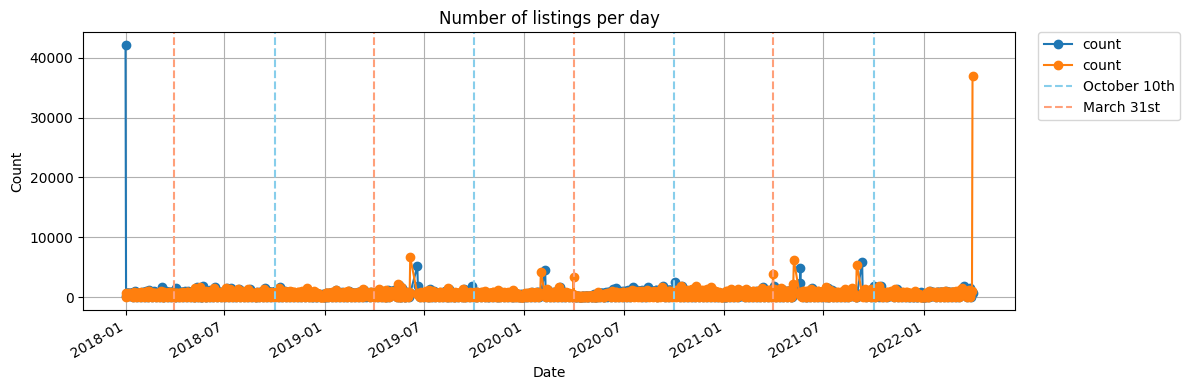

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the number of rows for each date
start_date_counts = dedup_df['zoo_start_date'].value_counts()
end_date_counts = dedup_df['zoo_end_date'].value_counts()

# Plot the results
plt.figure(figsize=(12, 4))
start_date_counts.plot(kind='line', marker='o')
end_date_counts.plot(kind='line', marker='o')
plt.title('Number of listings per day')
plt.xlabel('Date')
plt.ylabel('Count')

plt.axvline(x=pd.Timestamp('2018-10-01'), color='skyblue', linestyle='--', label="October 10th") # type: ignore
plt.axvline(x=pd.Timestamp('2019-10-01'), color='skyblue', linestyle='--') # type: ignore
plt.axvline(x=pd.Timestamp('2020-10-01'), color='skyblue', linestyle='--') # type: ignore
plt.axvline(x=pd.Timestamp('2021-10-01'), color='skyblue', linestyle='--') # type: ignore

plt.axvline(x=pd.Timestamp('2018-03-31'), color='#FFA07A', linestyle='--', label="March 31st") # type: ignore
plt.axvline(x=pd.Timestamp('2019-03-31'), color='#FFA07A', linestyle='--') # type: ignore
plt.axvline(x=pd.Timestamp('2020-03-31'), color='#FFA07A', linestyle='--') # type: ignore
plt.axvline(x=pd.Timestamp('2021-03-31'), color='#FFA07A', linestyle='--') # type: ignore

plt.legend(bbox_to_anchor=(1.025, 1), loc='upper left', borderaxespad=0)
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
dedup_df[dedup_df['zoo_end_date'] == '2019-03-31']['zoo_listing_id'].value_counts()

zoo_listing_id
50979535    1
37057616    1
37514422    1
41807456    1
50689170    1
           ..
44859005    1
44859006    1
45304572    1
45370375    1
45370394    1
Name: count, Length: 84, dtype: int64

In [13]:
zoo_2021_df[zoo_2021_df['zoo_listing_id'] == 48576037]

,zoo_listing_id,zoo_property_id,zoo_property_type,zoo_start_date,zoo_end_date,zoo_price_first,zoo_price_last,zoo_price_min,zoo_price_max,zoo_price_unique,zoo_price_flag,zoo_num_bed_first,zoo_num_bed_last,zoo_num_bed_min,zoo_num_bed_max,zoo_bed_flag,zoo_num_floors_min,zoo_num_floors_max,zoo_num_bath_min,zoo_num_bath_max,zoo_num_reception_min,zoo_num_reception_max,zoo_pcu,zoo_lon,zoo_lat,zoo_address,zoo_street_name,zoo_property_num,zoo_post_town,zoo_country,zoo_county,zoo_category,zoo_branch_id,zoo_agent_name,zoo_agent_address,zoo_agent_postcode,zoo_bullet,zoo_lad20nm
89052,48576037,10167333,Flat,2020-10-01,2021-04-15,95000,95000,95000,95000,[95000],1,1,1,1,1,1,0,0,1,1,1,1,HA2 8EU,-0.358797,51.562305,"Corbins Lane, Harrow HA2",Corbins Lane,5 Barnetts Court,Harrow,England,London,Residential,2275,David Conway & Co Ltd,"269 Northolt Road, South Harrow",HA2 8HS,"[""100 Yards To Shops, 500 Yards To Tube"", ""Kit...",Harrow
89053,48576037,10167333,Flat,2021-09-10,2021-11-09,77500,77500,77500,77500,[77500],1,1,1,1,1,1,0,0,1,1,1,1,HA2 8EU,-0.359616,51.5622,"Corbins Lane, Harrow HA2",Corbins Lane,5 Barnetts Court,Harrow,England,London,Residential,2275,David Conway & Co Ltd,"269 Northolt Road, South Harrow",HA2 8HS,"[""100 Yards To Shops, 500 Yards To Tube"", ""Kit...",Harrow


In [14]:
address_counts = all_zoo_df.groupby('zoo_listing_id')['zoo_pcu'].nunique()
print(address_counts[address_counts > 1].index)

Index([ 3679279, 32031369, 34634694, 35394007, 37161626, 38077963, 38077964,
       38592636, 39195766, 39474191,
       ...
       59826411, 59848761, 59881281, 59926800, 59999279, 60017152, 60116891,
       60336515, 60417233, 60541183],
      dtype='int64', name='zoo_listing_id', length=1084)


In [15]:
all_zoo_df[all_zoo_df['zoo_listing_id'] == 34634694].sort_values(by=['zoo_listing_id', 'zoo_property_id', 'zoo_start_date'])

,zoo_listing_id,zoo_property_id,zoo_property_type,zoo_start_date,zoo_end_date,zoo_price_first,zoo_price_last,zoo_price_min,zoo_price_max,zoo_price_unique,zoo_price_flag,zoo_num_bed_first,zoo_num_bed_last,zoo_num_bed_min,zoo_num_bed_max,zoo_bed_flag,zoo_num_floors_min,zoo_num_floors_max,zoo_num_bath_min,zoo_num_bath_max,zoo_num_reception_min,zoo_num_reception_max,zoo_pcu,zoo_lon,zoo_lat,zoo_address,zoo_street_name,zoo_property_num,zoo_post_town,zoo_country,zoo_county,zoo_category,zoo_branch_id,zoo_agent_name,zoo_agent_address,zoo_agent_postcode,zoo_bullet,zoo_lad20nm
209464,34634694,23248147,Houseboat,2018-01-01,2018-01-10,980000.0,980000.0,980000.0,980000.0,[980000.],1,3,3,3,3,1,0,0,2,2,1,1,SW11 3RR,-0.1777369999999999,51.471397,"Oyster Pier, Battersea SW11",Oyster Pier Lombard Road,Barge Janny,London,England,London,Residential,9539,"riverhomes, South West London office","1-3 Lower Richmond Road, Putney",SW15 1EJ,[],Wandsworth
205548,34634694,23248147,Houseboat,2018-08-02,2019-03-31,850000.0,850000.0,850000.0,850000.0,[850000.],1,3,3,3,3,1,0,0,2,2,1,1,SW11 3RR,-0.1777369999999999,51.471397,"Oyster Pier, Battersea SW11",Oyster Pier Lombard Road,Barge Janny,London,England,London,Residential,9539,"riverhomes, South West London office","1-3 Lower Richmond Road, Putney",SW15 1EJ,[],Wandsworth
518789,34634694,23248147,Houseboat,2018-10-01,2020-03-31,850000.0,850000.0,850000.0,850000.0,[850000],1,3,3,3,3,1,0,0,2,2,1,1,SW11 3RR,-0.1777369999999999,51.471397,"Oyster Pier, Battersea SW11",Oyster Pier Lombard Road,Barge Janny,London,England,London,Residential,9539,"riverhomes, South West & Central London office","1-3 Lower Richmond Road, Putney",SW15 1EJ,"[""Residential Mooring with a 113 years lease"",...",Wandsworth
863027,34634694,23248147,Houseboat,2019-10-01,2020-09-11,850000.0,850000.0,850000.0,850000.0,[850000],1,3,3,3,3,1,0,0,2,2,1,1,SW11 3RP,-0.178515,51.47113,"Oyster Pier, Battersea SW11",Oyster Pier Lombard Road,Barge Janny,London,England,London,Residential,9539,"riverhomes, South West & Central London office","1-3 Lower Richmond Road, Putney",SW15 1EJ,"[""Residential Mooring with a 113 years lease"",...",Wandsworth


In [16]:
# 48576037
dedup_df[dedup_df['zoo_listing_id'] == 34634694].sort_values(by=['zoo_listing_id', 'zoo_property_id', 'zoo_start_date'])

,zoo_listing_id,zoo_property_id,zoo_property_type,zoo_start_date,zoo_end_date,zoo_price_first,zoo_price_last,zoo_price_min,zoo_price_max,zoo_price_unique,zoo_price_flag,zoo_num_bed_first,zoo_num_bed_last,zoo_num_bed_min,zoo_num_bed_max,zoo_bed_flag,zoo_num_floors_min,zoo_num_floors_max,zoo_num_bath_min,zoo_num_bath_max,zoo_num_reception_min,zoo_num_reception_max,zoo_pcu,zoo_lon,zoo_lat,zoo_address,zoo_street_name,zoo_property_num,zoo_post_town,zoo_country,zoo_county,zoo_category,zoo_branch_id,zoo_agent_name,zoo_agent_address,zoo_agent_postcode,zoo_bullet,zoo_lad20nm
zoo_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
209464,34634694,23248147,Houseboat,2018-01-01,2018-01-10,980000.0,980000.0,980000.0,980000.0,[980000.],1,3,3,3,3,1,0,0,2,2,1,1,SW11 3RR,-0.1777369999999999,51.471397,"Oyster Pier, Battersea SW11",Oyster Pier Lombard Road,Barge Janny,London,England,London,Residential,9539,"riverhomes, South West London office","1-3 Lower Richmond Road, Putney",SW15 1EJ,[],Wandsworth
205548,34634694,23248147,Houseboat,2018-08-02,2020-03-31,850000.0,850000.0,850000.0,850000.0,[850000.],1,3,3,3,3,1,0,0,2,2,1,1,SW11 3RR,-0.1777369999999999,51.471397,"Oyster Pier, Battersea SW11",Oyster Pier Lombard Road,Barge Janny,London,England,London,Residential,9539,"riverhomes, South West London office","1-3 Lower Richmond Road, Putney",SW15 1EJ,[],Wandsworth


In [17]:
dedup_df['zoo_listing_id'].value_counts()

zoo_listing_id
50987913    11
48527224     9
47007122     8
55900441     8
53772705     8
            ..
51998721     1
51998760     1
51998771     1
51998775     1
46139947     1
Name: count, Length: 771816, dtype: int64

In [18]:
dedup_df[dedup_df['zoo_listing_id'] == 46225175]

,zoo_listing_id,zoo_property_id,zoo_property_type,zoo_start_date,zoo_end_date,zoo_price_first,zoo_price_last,zoo_price_min,zoo_price_max,zoo_price_unique,zoo_price_flag,zoo_num_bed_first,zoo_num_bed_last,zoo_num_bed_min,zoo_num_bed_max,zoo_bed_flag,zoo_num_floors_min,zoo_num_floors_max,zoo_num_bath_min,zoo_num_bath_max,zoo_num_reception_min,zoo_num_reception_max,zoo_pcu,zoo_lon,zoo_lat,zoo_address,zoo_street_name,zoo_property_num,zoo_post_town,zoo_country,zoo_county,zoo_category,zoo_branch_id,zoo_agent_name,zoo_agent_address,zoo_agent_postcode,zoo_bullet,zoo_lad20nm
zoo_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
170670,46225175,21133294,Flat,2018-01-14,2018-05-01,150000.0,250000.0,150000.0,250000.0,[150000. 250000.],2,2,2,2,2,1,0,0,1,1,1,1,SE18 5QY,0.049069,51.493732,"Ruston Road, London, London SE18",Ruston Road,149,London,England,London,Residential,13777,House Network,"Units 13 & 13a, Estate Offices, Radley Green F...",CM4 0LU,"[""No Chain, Vacant Possession, Offstreet Parki...",Greenwich
170422,46225175,21133294,Flat,2018-06-15,2018-07-13,250000.0,250000.0,250000.0,250000.0,[250000.],1,2,2,2,2,1,0,0,1,1,1,1,SE18 5QY,0.049069,51.493732,"Ruston Road, London, London SE18",Ruston Road,149,London,England,London,Residential,13777,House Network,"Units 13 & 13a, Estate Offices, Radley Green F...",CM4 0LU,"[""No Chain, Vacant Possession, Offstreet Parki...",Greenwich
170397,46225175,21133294,Flat,2018-08-31,2019-01-15,250000.0,285000.0,240000.0,285000.0,[250000. 240000. 285000.],3,2,2,2,2,1,0,0,1,1,1,1,SE18 5QY,0.049069,51.493732,"Ruston Road, London, London SE18",Ruston Road,149,London,England,London,Residential,13777,House Network,"Units 13 & 13a, Estate Offices, Radley Green F...",CM4 0LU,"[""No Chain, Vacant Possession, Offstreet Parki...",Greenwich


There are couple of additional features we could add to the Zoopla dataset. One the listing duration, which could be calculated by subtracting the listing start date from the last listing end date. Another feature could be the total number of listed properties during the listing period, and the hypnosis is that the more properties are listed, the lower the price will be. We take the view that, the number of properties listed just before the advertisement is taken down is a better indicator of the demand for the property, therefore we use the `zoo_end_date` to calculate the number of properties listed at that point in time.

We can use the numpy matrix operations to work on the entire dataset at once by calculating arrays of starting and ending dates for each property, and sum up the number of properties listed that have started by not ended for each listing. This is a very efficient way of calculating the number of properties listed for each property however the problem is that it requires a lot of memory. It runs fine with a 1k sample set but it would run out of memory on my 16 GB RAM machine even for a small subset (Bromley only, for instance).

In [19]:
dedup_df[['zoo_start_date', 'zoo_end_date']].memory_usage(deep=True).sum()

21206928

In [20]:
sample_df = dedup_df.sample(1000, random_state=42)

In [21]:
from datetime import datetime

def aggregate_running_listing(data):
    df = data.copy()
    dates_df = data[['zoo_start_date', 'zoo_end_date']].copy()
    start_dates = np.array(dates_df['zoo_start_date']).reshape(-1, 1)
    end_dates = np.array(dates_df['zoo_end_date']).reshape(-1, 1)

    # Calculate the number of items that have started but not ended yet
    started_not_ended = np.sum((end_dates.T >= end_dates) & (start_dates.T <= end_dates), axis=1)

    # Add the results to the DataFrame
    dates_df['zoo_started_not_ended'] = started_not_ended
    df['zoo_started_not_ended'] = dates_df['zoo_started_not_ended']

    return df

aggregate_running_listing(sample_df).sort_values(by='zoo_start_date')

,zoo_listing_id,zoo_property_id,zoo_property_type,zoo_start_date,zoo_end_date,zoo_price_first,zoo_price_last,zoo_price_min,zoo_price_max,zoo_price_unique,zoo_price_flag,zoo_num_bed_first,zoo_num_bed_last,zoo_num_bed_min,zoo_num_bed_max,zoo_bed_flag,zoo_num_floors_min,zoo_num_floors_max,zoo_num_bath_min,zoo_num_bath_max,zoo_num_reception_min,zoo_num_reception_max,zoo_pcu,zoo_lon,zoo_lat,zoo_address,zoo_street_name,zoo_property_num,zoo_post_town,zoo_country,zoo_county,zoo_category,zoo_branch_id,zoo_agent_name,zoo_agent_address,zoo_agent_postcode,zoo_bullet,zoo_lad20nm,zoo_started_not_ended
zoo_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
103974,45626233,11933062,Detached house,2018-01-01,2018-07-04,900000.0,780000.0,780000.0,900000.0,[900000. 780000.],2,5,5,5,5,1,0,0,0,0,0,0,KT20 7BG,-0.208576,51.260914,"Margery Lane, Lower Kingswood, Tadworth KT20",Margery Lane,Rosevale,Tadworth,England,Surrey,Residential,13537,Cairds Estate Agents,"128-130 High Street, Epsom",KT19 8BT,"[""Substantial And Private Plot"", ""Multiple Bed...",Reigate and Banstead,63
153879,45574641,32355452,Flat,2018-01-01,2018-04-05,451500.0,451500.0,451500.0,451500.0,[451500.],1,2,2,2,2,1,0,0,1,1,0,0,NW9 4BR,-0.2458179999999999,51.597313,"Bristol Avenue, Colindale NW9",Bristol Avenue,15 Jaguar Court,Edgware,England,London,Residential,87506,Genesis - Casa Court,"Bristol Avenue, Barnet",NW9 4BW,"[""Oak engineered wooden floors in living areas...",Barnet,62
444,43828340,2588250,Detached house,2018-01-01,2018-03-07,595000.0,595000.0,595000.0,595000.0,[595000.],1,4,4,4,4,1,0,0,2,2,2,2,BR8 7SJ,0.190713,51.414677000000005,"Maude Road, Hextable, Kent BR8",Hextable Kent,3 Maude Road,Swanley,England,Kent,Residential,12861,Robinson Jackson - Swanley,"39 High Street, Swanley",BR8 8AE,"[""Hextable Village"", ""Detached"", ""4 Double Bed...",Sevenoaks,60
145900,44225575,17298592,Semi-detached house,2018-01-01,2018-09-04,339900.0,339900.0,339900.0,339900.0,[339900.],1,3,3,3,3,1,0,0,0,0,0,0,NW9 7HA,-0.24866,51.582375,"Hyde Crescent, London NW9",LONDON,2 Hyde Crescent,London,England,London,Residential,83908,Homewise Ltd,"1 Liverpool Gardens, Worthing",BN11 1TF,"[""Over 60s only under Homewise's lifetime leas...",Barnet,58
91194,46057337,11091586,Terraced house,2018-01-01,2018-01-04,500000.0,500000.0,500000.0,500000.0,[500000.],1,2,2,2,2,1,0,0,1,1,1,1,IG8 7ND,0.040419,51.610607,"Prospect Road, Woodford Green IG8",Prospect Road,123,Woodford Green,England,Essex,Residential,16274,Lawlors - Woodford,"457 High Road, Woodford Green",IG8 0XE,"[""Victorian Mid-Terraced House"", ""Two Double B...",Redbridge,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210639,61094489,21856634,End terrace house,2022-03-26,2022-03-31,700000.0,700000.0,700000.0,700000.0,[700000],1,3,3,3,3,1,0,0,1,1,1,1,SM3 8PT,-0.21513,51.36057,"Church Farm Lane, Cheam, Cheam Village, Surrey...",Cheam,7 Church Farm Lane,Sutton,England,London,Residential,30106,Fine & Country - Cheam,"28 Ewell Road, Sutton",SM3 8BU,"[""Moments off Nonsuch Park"", ""Extended Kitchen...",Sutton,41
1291529,61071864,24922837,Flat,2022-03-26,2022-03-31,275000.0,275000.0,275000.0,275000.0,[275000],1,2,2,2,2,1,0,0,2,2,0,0,UB5 6TT,-0.366852,51.537605,"Farrier Road, Northolt UB5",Farrier Road,47,Northolt,England,London,Residential,52785,Winkworth - Harrow,"144 Station Road, Harrow",HA1 2RH,[],Ealing,41
1328710,61097258,25527580,Flat,2022-03-27,2022-03-31,375000.0,375000.0,375000.0,375000.0,[375000],1,2,2,2,2,1,0,0,2,2,1,1,WD18 7BL,-0.417988,51.656086,"Metropolitan Station Approach, Watford WD18",Catalonia Apartments,22,Watford,England,Hertfordshire,Residential,58128,Dey King & Haria Ltd,"129 The Parade, High Street, Watford",WD17 1NA,"[""Chain Free"", ""Two Double Bedrooms"", ""Two Bat...",Watford,41


Another option is to do this sequentially, which is what we do here. We iterate over the dataset and calculate the number of properties listed for each property. This is a slower process (roughly `52m 59s` for `799715` records ~ `0.004s` per record), but is guaranteed to work on any machine for dataset of any size.

In [22]:
def count_started_not_ended(df, end_date):
    return ((df['zoo_start_date'] <= end_date) & (end_date <= df['zoo_end_date'])).sum()

# date = pd.to_datetime('2018-02-03 00:00:00')
def aggregate_running_listing_sequential(data, null_date=None):
    df = data.copy()

    # Calculate the number of items that have started but not ended yet
    started_not_ended = df.apply(lambda x: None if x['zoo_start_date'] == null_date else count_started_not_ended(df, x['zoo_end_date']), axis=1)

    # Add the results to the DataFrame
    df['zoo_started_not_ended'] = started_not_ended
    return df

# aggregate_running_listing_sequential(test_df, null_date=datetime(2018, 2, 1)).sort_values(by='zoo_start_date')

In [23]:
vector_results = aggregate_running_listing(sample_df).sort_values(by='zoo_start_date')
sequential_results = aggregate_running_listing_sequential(sample_df).sort_values(by='zoo_start_date')

print(len(vector_results.loc[vector_results['zoo_started_not_ended'] != sequential_results['zoo_started_not_ended']]))
print(len(sequential_results.loc[sequential_results['zoo_started_not_ended'] != vector_results['zoo_started_not_ended']]))

0
0


In [24]:
dedup_df[dedup_df['zoo_listing_id'] == 47576398][[
  'zoo_listing_id', 
  'zoo_property_id',
  'zoo_start_date',
  'zoo_end_date',
  'zoo_pcu', 
  'zoo_address',	
  'zoo_street_name', 
  'zoo_property_num'
]]

,zoo_listing_id,zoo_property_id,zoo_start_date,zoo_end_date,zoo_pcu,zoo_address,zoo_street_name,zoo_property_num
zoo_id,,,,,,,,
210726,47576398,30013325,2018-05-11,2019-03-22,SW6 1UE,"Cambium Apartments, 1 Beatrice Place SW19",Beatrice Place,Flat 18 (Plot 83) Cambium Apartments 1
877356,47576398,32881529,2020-10-24,2021-03-29,SW19 6BU,"Cambium Apartments, 1 Beatrice Place SW19",Beatrice Place,Flat 18 Cambium Apartments 1


In [25]:
dedup_df[dedup_df['zoo_listing_id'] == 47576398]

,zoo_listing_id,zoo_property_id,zoo_property_type,zoo_start_date,zoo_end_date,zoo_price_first,zoo_price_last,zoo_price_min,zoo_price_max,zoo_price_unique,zoo_price_flag,zoo_num_bed_first,zoo_num_bed_last,zoo_num_bed_min,zoo_num_bed_max,zoo_bed_flag,zoo_num_floors_min,zoo_num_floors_max,zoo_num_bath_min,zoo_num_bath_max,zoo_num_reception_min,zoo_num_reception_max,zoo_pcu,zoo_lon,zoo_lat,zoo_address,zoo_street_name,zoo_property_num,zoo_post_town,zoo_country,zoo_county,zoo_category,zoo_branch_id,zoo_agent_name,zoo_agent_address,zoo_agent_postcode,zoo_bullet,zoo_lad20nm
zoo_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
210726,47576398,30013325,Flat,2018-05-11,2019-03-22,589000.0,619000.0,556000.0,619000.0,[589000. 599000. 556000. 590000. 619000.],5,2,2,2,2,1,0,0,2,2,1,1,SW6 1UE,-0.198289,51.486263,"Cambium Apartments, 1 Beatrice Place SW19",Beatrice Place,Flat 18 (Plot 83) Cambium Apartments 1,London,England,London,Residential,16942,Moving City,"18C Mansell Street, Aldgate, London",E1 8AA,"[""Two Bedrooms, Two Bathrooms"", ""Size: 778 Sq....",Hammersmith and Fulham
877356,47576398,32881529,Flat,2020-10-24,2021-03-29,595000.0,595000.0,595000.0,595000.0,[595000],1,2,2,2,2,1,0,0,2,2,1,1,SW19 6BU,-0.219901,51.44797,"Cambium Apartments, 1 Beatrice Place SW19",Beatrice Place,Flat 18 Cambium Apartments 1,London,England,London,Residential,16942,Moving City,"WeWork, Aldgate Tower, 2 Leman Street, London",E1 8FA,"[""Two Bedrooms, Two Bathrooms"", ""Internal size...",Wandsworth


In [26]:
len(dedup_df)

883622

Zoopla dataset may also contain multiple entries for the same property. This is because the same property may be listed multiple times, but the listing should still be counted when aggregating the total number of listings. For the preprocessing, we will first aggregate the running total of properties listed for each property, and then we will calculate the listing duration for each property.

It has also become apparent that the Zoopla dataset contains repeated entries for the same property. This is because the same property may be listed multiple times, by the same agent (with the same listing id), or different agents (with different listing ids). We will remove the duplicates by keeping only the first entry for each property.

Finally, we will remove the duplicates by keeping only the first entry for each property.

In [27]:
from modules.utils import format_ratio, load_data, save_data

def preprocessing(df, use_cache=True):
    saved_name = 'saved_all_zoopla_sales_processed'
    df = df.copy()

    saved_df = load_data(
        saved_name,
        lambda f: pd.read_csv(
            f, header=0, parse_dates=['zoo_start_date', 'zoo_end_date'], low_memory=False
        )
    )

    # Load saved data if it exists
    if saved_df is not None and use_cache:
        return saved_df
    
    # Add a column for the number of total listings
    df = aggregate_running_listing_sequential(df)

    # Calculate the duration of the listing
    df['zoo_duration'] = (df['zoo_end_date'] - df['zoo_start_date']).dt.days
    # Indicate the change in price
    df['zoo_price_increase'] = df['zoo_price_last'] > df['zoo_price_first']
    
    # Add `Auction` column
    df['zoo_auction'] = df['zoo_bullet'].apply(lambda bullet: 'auction' in bullet.lower())
    # Add `Ground/Top Floor` column
    df['zoo_ground_or_top_floor'] = df['zoo_bullet'].apply(lambda bullet: 'Ground' if 'ground floor' in bullet.lower() else 'Top' if 'top floor' in bullet.lower() else None)
    # Add `Garage` column
    df['zoo_garage'] = df['zoo_bullet'].apply(lambda bullet: 'garage' in bullet.lower())
    # Add `Shared Ownership` column
    df['zoo_shared_ownership'] = df['zoo_bullet'].apply(lambda bullet: 'shared ownership' in bullet.lower())

    # Save a copy of the processed data
    csv_file = os.path.join('./data/input', f'{saved_name}.csv')
    print(f'Saving data to {csv_file}...')
    df.to_csv(csv_file)

    return df

# Long processing time, 454m 7.4s original, 63m 35.5s deduped - use cache
processed_df = preprocessing(dedup_df)

print('Retained rate:', len(processed_df), format_ratio(len(processed_df), len(dedup_df)))

Loading saved data from ./data/saved/saved_all_zoopla_sales_processed.parquet...
Retained rate: 883622 100.0000%


In [28]:
processed_df.columns

Index(['zoo_id', 'zoo_listing_id', 'zoo_property_id', 'zoo_property_type',
       'zoo_start_date', 'zoo_end_date', 'zoo_price_first', 'zoo_price_last',
       'zoo_price_min', 'zoo_price_max', 'zoo_price_unique', 'zoo_price_flag',
       'zoo_num_bed_first', 'zoo_num_bed_last', 'zoo_num_bed_min',
       'zoo_num_bed_max', 'zoo_bed_flag', 'zoo_num_floors_min',
       'zoo_num_floors_max', 'zoo_num_bath_min', 'zoo_num_bath_max',
       'zoo_num_reception_min', 'zoo_num_reception_max', 'zoo_pcu', 'zoo_lon',
       'zoo_lat', 'zoo_address', 'zoo_street_name', 'zoo_property_num',
       'zoo_post_town', 'zoo_country', 'zoo_county', 'zoo_category',
       'zoo_branch_id', 'zoo_agent_name', 'zoo_agent_address',
       'zoo_agent_postcode', 'zoo_bullet', 'zoo_lad20nm',
       'zoo_started_not_ended', 'zoo_duration', 'zoo_price_increase',
       'zoo_auction', 'zoo_ground_or_top_floor', 'zoo_garage',
       'zoo_shared_ownership'],
      dtype='object')

Some initial data exploration:

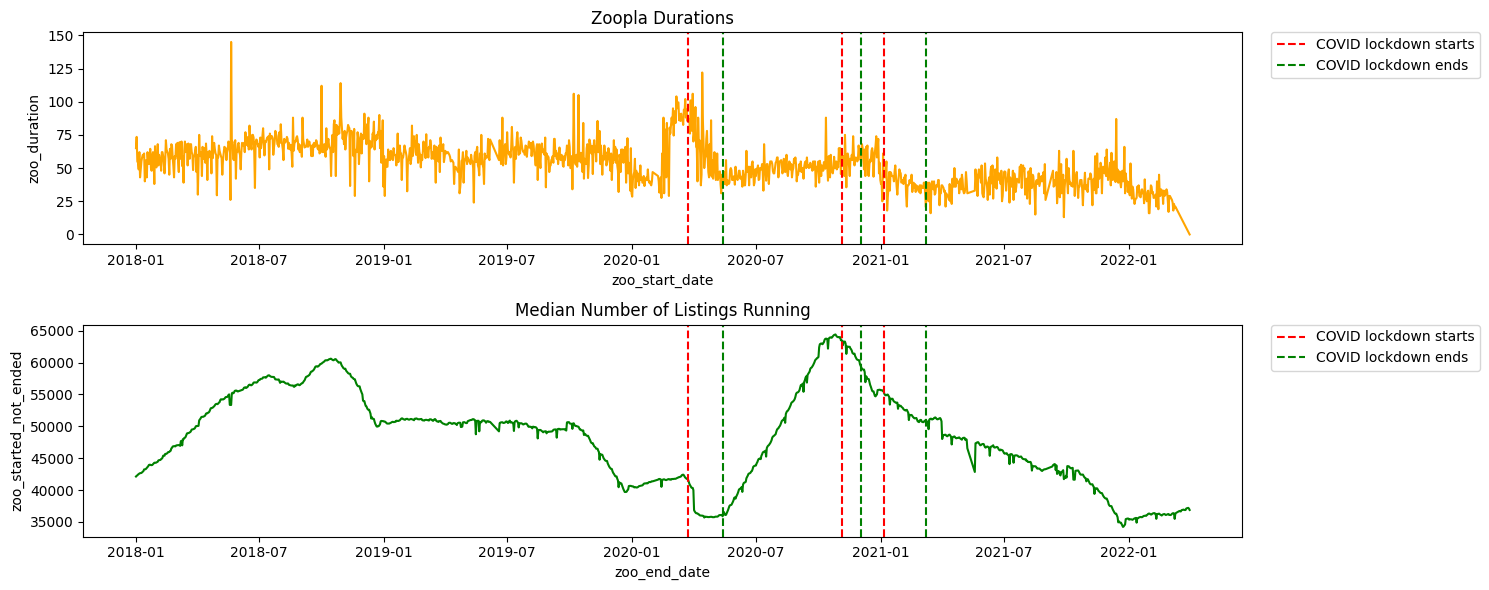

In [29]:
fig = plt.figure(figsize=(15, 6))

fig.add_subplot(2,1,1)
sns.lineplot(x='zoo_start_date', y='zoo_duration', data=processed_df.groupby(['zoo_start_date'])['zoo_duration'].agg('median').reset_index(), color='orange')
# COVID lockdowns
plt.axvline(x=pd.Timestamp('2020-03-23'), color='r', linestyle='--', label='COVID lockdown starts') # type: ignore
plt.axvline(x=pd.Timestamp('2020-05-13'), color='g', linestyle='--', label='COVID lockdown ends') # type: ignore

plt.axvline(x=pd.Timestamp('2020-11-05'), color='r', linestyle='--') # type: ignore
plt.axvline(x=pd.Timestamp('2020-12-02'), color='g', linestyle='--') # type: ignore

plt.axvline(x=pd.Timestamp('2021-01-06'), color='r', linestyle='--') # type: ignore
plt.axvline(x=pd.Timestamp('2021-03-08'), color='g', linestyle='--') # type: ignore

plt.legend(bbox_to_anchor=(1.025, 1), loc='upper left', borderaxespad=0)
plt.title('Zoopla Durations')

fig.add_subplot(2,1,2)
sns.lineplot(x='zoo_end_date', y='zoo_started_not_ended', data=processed_df.groupby(['zoo_end_date'])['zoo_started_not_ended'].agg('median').reset_index(), color='green')

# COVID lockdowns
plt.axvline(x=pd.Timestamp('2020-03-23'), color='r', linestyle='--', label='COVID lockdown starts') # type: ignore
plt.axvline(x=pd.Timestamp('2020-05-13'), color='g', linestyle='--', label='COVID lockdown ends') # type: ignore

plt.axvline(x=pd.Timestamp('2020-11-05'), color='r', linestyle='--') # type: ignore
plt.axvline(x=pd.Timestamp('2020-12-02'), color='g', linestyle='--') # type: ignore

plt.axvline(x=pd.Timestamp('2021-01-06'), color='r', linestyle='--') # type: ignore
plt.axvline(x=pd.Timestamp('2021-03-08'), color='g', linestyle='--') # type: ignore

# plt.axvline(x=pd.Timestamp('2018-03-31'), color='r', linestyle='--', label='31/03') # type: ignore
# plt.axvline(x=pd.Timestamp('2018-10-01'), color='g', linestyle='--', label='01/10') # type: ignore

# plt.axvline(x=pd.Timestamp('2019-03-31'), color='r', linestyle='--') # type: ignore
# plt.axvline(x=pd.Timestamp('2019-10-01'), color='g', linestyle='--') # type: ignore

# plt.axvline(x=pd.Timestamp('2020-03-31'), color='r', linestyle='--') # type: ignore
# plt.axvline(x=pd.Timestamp('2020-10-01'), color='g', linestyle='--') # type: ignore

# plt.axvline(x=pd.Timestamp('2021-03-31'), color='r', linestyle='--') # type: ignore
# plt.axvline(x=pd.Timestamp('2021-10-01'), color='g', linestyle='--') # type: ignore

plt.legend(bbox_to_anchor=(1.025, 1), loc='upper left', borderaxespad=0)
plt.title('Median Number of Listings Running')
plt.tight_layout()

Text(0.5, 1.0, 'Number of Listings Running')

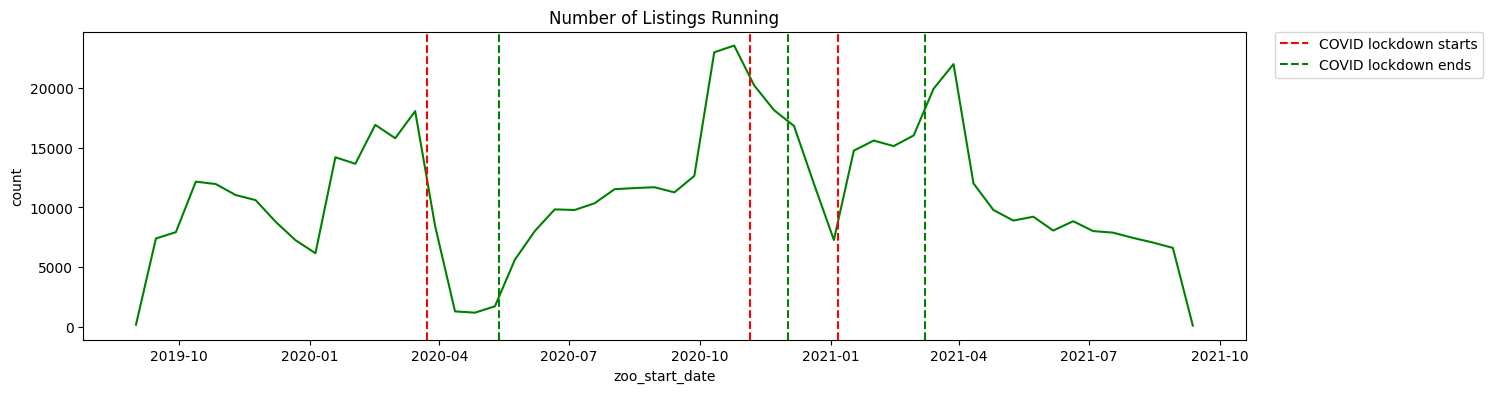

In [30]:
fig = plt.figure(figsize=(15, 4))

selected_df = all_zoo_df[(all_zoo_df['zoo_start_date'] >= pd.Timestamp('2019-09-01')) & (all_zoo_df['zoo_start_date'] <= pd.Timestamp('2021-09-01'))]
daily_start_df = selected_df.groupby(selected_df['zoo_start_date'].dt.floor('d')).size().reset_index(name='count')
monthly_start_df = daily_start_df[daily_start_df['count'] < 20000].set_index('zoo_start_date').resample('2W').sum().reset_index()

sns.lineplot(x='zoo_start_date', y='count', data=monthly_start_df, color='green')

# COVID lockdowns
plt.axvline(x=pd.Timestamp('2020-03-23'), color='r', linestyle='--', label='COVID lockdown starts') # type: ignore
plt.axvline(x=pd.Timestamp('2020-05-13'), color='g', linestyle='--', label='COVID lockdown ends') # type: ignore

plt.axvline(x=pd.Timestamp('2020-11-05'), color='r', linestyle='--') # type: ignore
plt.axvline(x=pd.Timestamp('2020-12-02'), color='g', linestyle='--') # type: ignore

plt.axvline(x=pd.Timestamp('2021-01-06'), color='r', linestyle='--') # type: ignore
plt.axvline(x=pd.Timestamp('2021-03-08'), color='g', linestyle='--') # type: ignore

plt.legend(bbox_to_anchor=(1.025, 1), loc='upper left', borderaxespad=0)
plt.title('Number of Listings Running')

The longest running listing

In [31]:
processed_df[processed_df['zoo_duration'] == processed_df['zoo_duration'].max()].head(5)

,zoo_id,zoo_listing_id,zoo_property_id,zoo_property_type,zoo_start_date,zoo_end_date,zoo_price_first,zoo_price_last,zoo_price_min,zoo_price_max,zoo_price_unique,zoo_price_flag,zoo_num_bed_first,zoo_num_bed_last,zoo_num_bed_min,zoo_num_bed_max,zoo_bed_flag,zoo_num_floors_min,zoo_num_floors_max,zoo_num_bath_min,zoo_num_bath_max,zoo_num_reception_min,zoo_num_reception_max,zoo_pcu,zoo_lon,zoo_lat,zoo_address,zoo_street_name,zoo_property_num,zoo_post_town,zoo_country,zoo_county,zoo_category,zoo_branch_id,zoo_agent_name,zoo_agent_address,zoo_agent_postcode,zoo_bullet,zoo_lad20nm,zoo_started_not_ended,zoo_duration,zoo_price_increase,zoo_auction,zoo_ground_or_top_floor,zoo_garage,zoo_shared_ownership
168514,272237,48073129,30429544,Flat,2018-06-21,2021-03-01,575000.0,575000.0,575000.0,575000.0,[575000.],1,2,2,2,2,1,0,0,1,1,1,1,W6 8LJ,-0.218703,51.485397,"Aspenlea Road, Hammersmith W6",Hammersmith,Aspenlea Road,London,England,London,Residential,54590,Haus Properties Fulham,"99 Wandsworth Bridge Road, London",SW6 2TE,"[""Stunning interior designed garden flat"", ""Re...",Hammersmith and Fulham,50991,984,False,False,None,False,False


# Compare Zoolpa and Land Registry data

In [44]:
from modules.utils import load_saved_data

ppd_df = load_saved_data('1_ppd_epc_data')
# ppd_df = ppd_df[ppd_df['PPD_District'] == 'BROMLEY']

Loading saved data from ./data/saved/1_ppd_epc_data.parquet...


In [34]:
len(ppd_df)

453039

Zoopla asking price is the price that the seller is asking for the property. Land Registry sold price is the price that the property was sold for. We can compare the two to see how they compare. They seem to follow the same trend, but Zoopla asking price is consistently 10% higher than the sold price, which is probably expected.

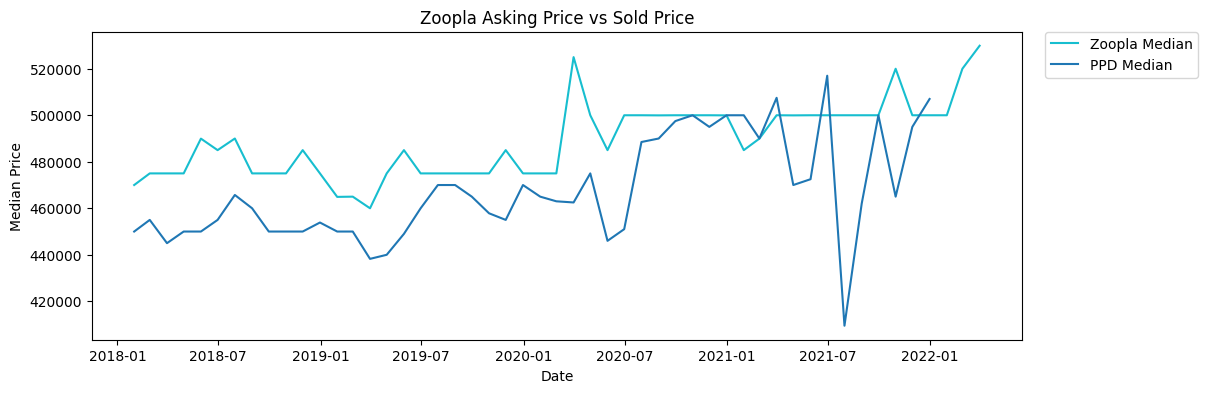

In [35]:
# Set the color palette
sns.set_palette("tab10")

zoo_median_price = processed_df.resample('M', on='zoo_end_date')['zoo_price_min'].median().reset_index()
ppd_median_price = ppd_df.resample('M', on='PPD_TransferDate')['PPD_Price'].median().reset_index()

plt.figure(figsize=(12, 4))

sns.lineplot(data=zoo_median_price, x='zoo_end_date', y='zoo_price_min', color=sns.color_palette()[9], label='Zoopla Median')
sns.lineplot(data=ppd_median_price, x='PPD_TransferDate', y='PPD_Price', color=sns.color_palette()[0], label='PPD Median')

plt.xlabel('Date')
plt.ylabel('Median Price')
plt.title('Zoopla Asking Price vs Sold Price')
plt.legend(bbox_to_anchor=(1.025, 1), loc='upper left', borderaxespad=0)
plt.show()

# Enrich the Price Paid dataset with Zoopla data.

The Zoopla dataset contains location information such as postcodes, addresses, and geographical coordinates. Of these, geographical coordinates provide the highest degree of accuracy, allowing us to align them with the coordinates present in the Price Paid dataset. To connect the Zoopla and Price Paid datasets, we first focus on the postcode. After locating all listed properties within a 10-meter radius, we then select the one that most closely aligns with the address. If no match is found, the process returns 'None'.

Address information within the Zoopla dataset is inconsistent and may contain inaccuracies or typos. The formatting can vary from one listing to another and might include the house number, street name, and city name. Even with fuzzy matching, we can only align about 36% of the addresses. However, this percentage can be increased through the implementation of multi-level fallback criteria. For instance, if an exact match can't be found, the system might attempt to find a property within an approximate location (e.g., within a 10-meter radius). If this fails, the system might then try to match the street name, and so on. While this method is not foolproof, it improves the chances of finding a match, taking the success rate up to approximately 54%.

Given that the address information in the Zoopla dataset tends to be less accurate than that in the Price Paid dataset, we will employ a priority-based approach. This approach involves defining a list of priority rules and attempting to match the address according to each one, but prioritizing matches from the highest-priority rule first.

The priority rules are as follows:

* Match on the most fields
* Match on the secondary address object name (SAON)
* Match on the geographical location within a 20-meter radius
* Match on the primary address object name (PAON)
* Match on the address to an extent of at least 85%

In [43]:
import modules.address as addr
import re

def str_concat(*args):
    filtered = filter(lambda x: pd.notna(x), args)
    mapped = list(map(lambda x: x.lower().replace('\'', '').replace('the ', '').strip(), filtered))
    return ', '.join([s.strip() for s in ','.join(mapped).split(',') if s])

def extract_door_number(address):
    flat_pattern = re.compile(r'\b(Flat|Apartment|Unit|Plot)\s+([A-Za-z0-9]+)', re.IGNORECASE)
    flat_match = flat_pattern.search(address)
    return flat_match.group(2) if flat_match else None

def extract_door_name(address):
    number_pattern = re.compile(r'(\b(Flat|Apartment|Unit|Plot)\s+\d+,?\s+)(\w.+)', re.IGNORECASE)
    number_match = number_pattern.search(address)
    return number_match.group(3) if number_match else None

def extract_number(address):
    number_pattern = re.compile(r'^(\d+\w*)', re.IGNORECASE)
    number_match = number_pattern.search(address)
    return number_match.group(1) if number_match else None

def extract_name(address):
    name_pattern = re.compile(r'(\d+\w*,?\s+)?([A-Za-z].+)?')
    name_match = name_pattern.search(address)
    return name_match.group(2) if name_match else None

def standardise_address(addr1, addr2, addr3 = None, addr4 = None):
    # Standardise address lines
    merged = str_concat(addr1, addr2, addr3, addr4).split(', ')
    first, rest = merged[0], merged[1:]

    # Extract the flat/apartment number and name from the first line
    secondary_num = extract_door_number(first)
    secondary_addr = extract_door_name(first)

    # If there is no flat/apartment information, extract the number and name from the first line
    if secondary_num is None and secondary_addr is None:
        secondary_num = extract_number(first)
        secondary_addr = extract_name(first)

    # If the secondary number or address is found in the rest of the address lines, remove it
    if  secondary_num is not None and len(rest) > 0 and rest[0].find(secondary_num) != -1:
        secondary_num = None 
    if  secondary_addr is not None and len(rest) > 0 and rest[0].find(secondary_addr) != -1:
        secondary_addr = None  

    # Carry out the same process for the rest address lines
    lines = np.array(list(zip(map(extract_number, rest), map(extract_name, rest)))).ravel()    

    return str_concat(secondary_num, secondary_addr, *lines)


print(standardise_address('Flat 9 Sixpenny Court', 'sixpenny court, tanner street, barking ig11'))
print(standardise_address('64 Brunswick House,', 'homefield rise, orpington br6'))
print(standardise_address('52 Brunswick Square', '52 brunswick square, homefield rise, orpington br6'))

9, sixpenny court, tanner street, barking ig11
64, brunswick house, homefield rise, orpington br6
52, brunswick square, homefield rise, orpington br6


Bear in mind that `property_id` in Zoopla dataset seems to be loosely used. It doesn't necessarily mean the same same property. It could be used multiple times for advertising multiple properties.

In [37]:
processed_df[processed_df['zoo_property_id'] == 32238675].sort_values(by=['zoo_listing_id']).head(10)

,zoo_id,zoo_listing_id,zoo_property_id,zoo_property_type,zoo_start_date,zoo_end_date,zoo_price_first,zoo_price_last,zoo_price_min,zoo_price_max,zoo_price_unique,zoo_price_flag,zoo_num_bed_first,zoo_num_bed_last,zoo_num_bed_min,zoo_num_bed_max,zoo_bed_flag,zoo_num_floors_min,zoo_num_floors_max,zoo_num_bath_min,zoo_num_bath_max,zoo_num_reception_min,zoo_num_reception_max,zoo_pcu,zoo_lon,zoo_lat,zoo_address,zoo_street_name,zoo_property_num,zoo_post_town,zoo_country,zoo_county,zoo_category,zoo_branch_id,zoo_agent_name,zoo_agent_address,zoo_agent_postcode,zoo_bullet,zoo_lad20nm,zoo_started_not_ended,zoo_duration,zoo_price_increase,zoo_auction,zoo_ground_or_top_floor,zoo_garage,zoo_shared_ownership
6662,184924,42100308,32238675,Flat,2018-01-01,2018-01-15,3700000.0,3700000.0,3700000.0,3700000.0,[3700000.],1,3,3,3,3,1,0,0,3,3,0,0,SE1 7TJ,-0.1215359999999999,51.491444,"The Corniche, Albert Embankment, London SE1","The Corniche,","B.9.36 The Corniche,",London,England,London,Residential,54168,Wigmore Jones,"3rd Floor, 111 Buckingham Palace Road",SW1W 0SR,"[""Gym"", ""Swimming Pool"", ""Balcony"", ""24 hour c...",Lambeth,43263,14,False,False,None,False,False
6663,184102,42100310,32238675,Flat,2018-01-01,2018-01-15,3600000.0,3600000.0,3600000.0,3600000.0,[3600000.],1,3,3,3,3,1,0,0,3,3,0,0,SE1 7TJ,-0.1215359999999999,51.491444,"The Corniche, Albert Embankment, London SE1","The Corniche,","B.6.23 The Corniche,",London,England,London,Residential,54168,Wigmore Jones,"3rd Floor, 111 Buckingham Palace Road",SW1W 0SR,"[""Gym"", ""Underfloor Heating"", ""Swimming Pool"",...",Lambeth,43263,14,False,False,None,False,False
6665,180295,42100389,32238675,Flat,2018-01-01,2018-01-15,2995000.0,2995000.0,2995000.0,2995000.0,[2995000.],1,3,3,3,3,1,0,0,3,3,0,0,SE1 7TJ,-0.1215359999999999,51.491444,"The Corniche, Albert Embankment, Albert Embank...",The Corniche,"B.14.57 The Corniche,",London,England,London,Residential,54168,Wigmore Jones,"3rd Floor, 111 Buckingham Palace Road",SW1W 0SR,"[""Gym"", ""Underfloor Heating"", ""Swimming Pool"",...",Lambeth,43263,14,False,False,None,False,False
7673,187971,42558801,32238675,Flat,2019-01-25,2019-01-25,1894995.0,1894995.0,1894995.0,1894995.0,[1894995.],1,2,2,2,2,1,0,0,2,2,0,0,SE1 7TY,-0.12339,51.48944,"Peninsula Heights, Albert Embankment, Lambeth,...","Peninsula Heights, Albert Embankment, Lambeth",Peninsula Heights,London,England,London,Residential,70168,LRC - London and Surrey Sales and Lettings agency,"35 Piccadilly, London",W1J 0DW,"[""Underground parking"", ""Porter/security"", ""Wo...",Lambeth,51061,0,False,False,None,False,False
7897,191217,42641659,32238675,Flat,2018-01-01,2018-08-06,2295000.0,2295000.0,2295000.0,2295000.0,[2295000.],1,2,2,2,2,1,0,0,2,2,0,0,SE1 7TL,-0.122648,51.4896,"Albert Embankment, London SE1",Albert Embankment,Merano Residences,London,England,London,Residential,74822,Keller Williams Prime Properties,"16 Berkeley Street, Mayfair, London",W1J 8DZ,[],Lambeth,57008,217,False,False,None,False,False
8919,183106,42894764,32238675,Flat,2018-01-01,2018-06-29,695000.0,695000.0,695000.0,695000.0,[695000.],1,1,1,1,1,1,0,0,1,1,1,1,SE1 7TJ,-0.1215359999999999,51.491444,"The Corniche, Tower One, 23 Albert Embankment,...",The Corniche,38 Tower One,None,None,None,Residential,62663,Garton Jones - Nine Elms & Vauxhall,9 Albert Embankment,SE1 7SP,"["" (48.87sq.M)"", ""1 Double Bedroom"", ""South Fa...",Lambeth,57006,179,False,False,None,False,False
9310,189455,42991327,32238675,Flat,2018-06-12,2018-07-16,3350000.0,3350000.0,3350000.0,3350000.0,[3350000.],1,3,3,3,3,1,0,0,3,3,0,0,SE1 7TJ,-0.1215359999999999,51.491444,"21 Albert Embankment, London SE1",21 Albert Embankment,B18.67 - 21 Albert Embankment,London,England,London,Residential,84098,St James - The Corniche,"23 Albert Embankment, London",SE1 7GG,"[""Balcony"", ""Underground parking"", ""Waterfront...",Lambeth,57996,34,False,False,None,False,False
9555,190854,43045231,32238675,Flat,2018-01-01,2018-04-24,1180000.0,1180000.0,1180000.0,1180000.0,[1180000.

In [39]:
import recordlinkage
import modules.utils as utils
from geopy.distance import geodesic
from recordlinkage.base import BaseCompareFeature

class CompareDateRange(BaseCompareFeature):
    def _compute_vectorized(self, transfer_date,  list_date):
        return list_date <= transfer_date
    
class CompareGeoCoordination(BaseCompareFeature):
    def _compute_vectorized(self, loc1, loc2):
        return np.array([geodesic(coord1, coord2).meters <= 10 for coord1, coord2 in zip(loc1, loc2)])    

def match_ppd_to_zoopla(ppd_df, zoo_df):
    ppd_df = ppd_df.copy()
    zoo_df = zoo_df.copy()

    # Add temporary geolocation columns and drop rows with missing values
    ppd_df['UPRN_LOC'] = ppd_df.apply(lambda x: (x['UPRN_LATITUDE'], x['UPRN_LONGITUDE']), axis=1)

    zoo_df.drop(zoo_df[zoo_df['zoo_lat'].isna() | zoo_df['zoo_lon'].isna()].index, inplace=True)
    zoo_df['zoo_loc'] = zoo_df.apply(lambda x: (x['zoo_lat'], x['zoo_lon']), axis=1)

    # Standardise address lines
    ppd_df['PPD_Merged'] = ppd_df.apply(lambda x: standardise_address(x['PPD_SAON'], x['PPD_PAON'], x['PPD_Street'], x['PPD_Postcode'].split(' ')[0] if x['ONSUD_BOROUGH'] is None else x['ONSUD_BOROUGH'] + ' ' + x['PPD_Postcode'].split(' ')[0]), axis=1)
    zoo_df['zoo_merged'] = zoo_df.apply(lambda x: standardise_address(x['zoo_property_num'], x['zoo_address']), axis=1)

    # Split secondary and primary address into separate columns for exact match
    split = ppd_df['PPD_Merged'].str.split(', ', expand=True)
    ppd_df['PPD_SAON_NEW'], ppd_df['PPD_PAON_1'], ppd_df['PPD_PAON_2'] = split[0], split[1], split[2]

    split = zoo_df['zoo_merged'].str.split(', ', expand=True)
    zoo_df['zoo_saon'], zoo_df['zoo_paon'] = split[0], split[1]

    # Block on postcode
    indexer = recordlinkage.Index()
    # indexer.block(left_on='PPD_Postcode', right_on='zoo_pcu')
    indexer.sortedneighbourhood(left_on='PPD_Postcode', right_on='zoo_pcu', window=5)
    candidates = indexer.index(ppd_df, zoo_df)
   
    comparer = recordlinkage.Compare()

    # The date must fall into correct range, i.e. the property must be listed before the transfer date
    comparer.add(CompareDateRange('PPD_TransferDate', 'zoo_end_date', label='CorrectDateRange'))

    # Location approximate match
    comparer.add(CompareGeoCoordination('UPRN_LOC', 'zoo_loc', label='Score_Geo'))
    # Exact match on SAON
    comparer.exact('PPD_SAON_NEW', 'zoo_saon', label='Score_SAON')
    # Alternative matches on PAON or SAON
    comparer.exact('PPD_PAON_1', 'zoo_paon', label='Score_PAON')
    comparer.string(left_on='PPD_Merged', right_on='zoo_merged', method='jarowinkler', threshold=0.85, label='Score_Address')

    features = comparer.compute(candidates, ppd_df, zoo_df)
    print(f'matched_count\n{features.sum(axis=1).value_counts().sort_index(ascending=False)}')

    features['Score'] = features.loc[:, 'Score_Geo':'Score_Address'].sum(axis=1)

    return features

from modules.utils import save_data, load_saved_data

# Add more boroughs to the list as needed
boroughs = np.sort(ppd_df['PPD_District'].unique()).tolist()

def process_borough(borough):
    ppd_condition = (ppd_df['PPD_District'] == borough) & (ppd_df['UPRN_LATITUDE'].notna())
    current_ppd_df = ppd_df[ppd_condition][['UPRN_LATITUDE', 'UPRN_LONGITUDE', 'PPD_SAON', 'PPD_PAON', 'PPD_Street', 'ONSUD_BOROUGH', 'PPD_Postcode', 'PPD_TransferDate']]
    
    current_zoo_df = processed_df[['zoo_lat', 'zoo_lon', 'zoo_property_num', 'zoo_address', 'zoo_pcu', 'zoo_end_date']]

    borough_features = match_ppd_to_zoopla(current_ppd_df, current_zoo_df).reset_index()
    borough_features.columns = ['PPD_ID', 'zoo_id'] + borough_features.columns[2:].tolist()
    save_data(borough_features, f'{borough}_features')


with utils.Timer() as t:
    for borough in boroughs:
        t.log(f'Started processing borough {borough}')
        process_borough(borough)

=== Started processing borough BARKING AND DAGENHAM (0.0000s) ===
matched_count
5.0     1448
4.0     5565
3.0    11181
2.0    39030
1.0    88812
0.0    65992
Name: count, dtype: int64
Saving data to ./data/saved/BARKING AND DAGENHAM_features.parquet...
=== Started processing borough BARNET (60.8487s) ===
matched_count
5.0      4743
4.0     16077
3.0     35758
2.0     82297
1.0    206714
0.0    176239
Name: count, dtype: int64
Saving data to ./data/saved/BARNET_features.parquet...
=== Started processing borough BEXLEY (155.0983s) ===
matched_count
5.0      3320
4.0     14819
3.0     43284
2.0     86763
1.0    184194
0.0    144575
Name: count, dtype: int64
Saving data to ./data/saved/BEXLEY_features.parquet...
=== Started processing borough BRENT (245.1789s) ===
matched_count
5.0      2463
4.0      9084
3.0     20419
2.0     46563
1.0    110759
0.0     90838
Name: count, dtype: int64
Saving data to ./data/saved/BRENT_features.parquet...
=== Started processing borough BROMLEY (312.5537s) 

In [40]:
processed_df['zoo_listing_id'].value_counts()

zoo_listing_id
50987913    11
48527224     9
47007122     8
55900441     8
53772705     8
            ..
51998721     1
51998760     1
51998771     1
51998775     1
46139947     1
Name: count, Length: 771816, dtype: int64

In [45]:
features = load_saved_data(f'BROMLEY_features')
features

Loading saved data from ./data/saved/BROMLEY_features.parquet...


In [49]:
import modules.utils as utils

ppd_zoo_df = pd.DataFrame()

with utils.Timer() as t:
    for borough in boroughs:
        features = load_saved_data(f'{borough}_features')
        matched = features[(features['Score'] > 2) & features['CorrectDateRange']]
        t.log(f'Matched count for {borough}: {len(matched)}')

        current_df = ppd_df[ppd_df['PPD_District'] == borough]
        current_df = pd.merge(current_df, matched, left_index=True, right_on='PPD_ID', how='left')
        current_df = pd.merge(current_df, processed_df, left_on='zoo_id', right_index=True, how='left')

        # With multiple matches, sort from the most to the least important match
        # criteria and keep the latest one with the highest score
        current_df = current_df.sort_values(by=['Score', 'Score_SAON', 'Score_Geo', 'Score_PAON', 'Score_Address', 'zoo_end_date']).drop_duplicates('PPD_ID', keep='last')
        
        # Only keep Zoopla columns, PPD_ID and a few key columns for validation
        columns = ['PPD_ID','PPD_Price','PPD_TransferDate','zoo_property_id','zoo_property_type','zoo_start_date','zoo_end_date','zoo_price_first','zoo_price_last','zoo_price_min','zoo_price_max','zoo_price_unique','zoo_price_flag','zoo_price_increase','zoo_num_bed_first','zoo_num_bed_last','zoo_num_bed_min','zoo_num_bed_max','zoo_bed_flag','zoo_num_floors_min','zoo_num_floors_max','zoo_num_bath_min','zoo_num_bath_max','zoo_num_reception_min','zoo_num_reception_max','zoo_pcu','zoo_lon','zoo_lat','zoo_address','zoo_street_name','zoo_property_num','zoo_post_town','zoo_country','zoo_county','zoo_category','zoo_branch_id','zoo_agent_name','zoo_agent_address','zoo_agent_postcode','zoo_duration', 'zoo_auction','zoo_ground_or_top_floor','zoo_garage','zoo_shared_ownership','zoo_bullet','zoo_lad20nm','zoo_started_not_ended']

        ppd_zoo_df = pd.concat([ppd_zoo_df, current_df], ignore_index=True)
    t.log(f'Finished loading all boroughs')

# Set index to PPD_ID
ppd_zoo_df.set_index('PPD_ID', inplace=True)

matched_count = len(ppd_zoo_df[~ppd_zoo_df['zoo_property_id'].isna()])
with_geo_info_count = len(ppd_df[ppd_df['UPRN_LATITUDE'].notna()])
print('Matching rate:', utils.format_ratio(matched_count, with_geo_info_count), matched_count, end='\n\n')

Loading saved data from ./data/saved/BARKING AND DAGENHAM_features.parquet...
=== Matched count for BARKING AND DAGENHAM: 6890 (0.0520s) ===
Loading saved data from ./data/saved/BARNET_features.parquet...
=== Matched count for BARNET: 20200 (0.3503s) ===
Loading saved data from ./data/saved/BEXLEY_features.parquet...
=== Matched count for BEXLEY: 17791 (0.7864s) ===
Loading saved data from ./data/saved/BRENT_features.parquet...
=== Matched count for BRENT: 11126 (1.1738s) ===
Loading saved data from ./data/saved/BROMLEY_features.parquet...
=== Matched count for BROMLEY: 20700 (1.5590s) ===
Loading saved data from ./data/saved/CAMDEN_features.parquet...
=== Matched count for CAMDEN: 11093 (2.0584s) ===
Loading saved data from ./data/saved/CITY OF LONDON_features.parquet...
=== Matched count for CITY OF LONDON: 1372 (2.3792s) ===
Loading saved data from ./data/saved/CITY OF WESTMINSTER_features.parquet...
=== Matched count for CITY OF WESTMINSTER: 12953 (2.6078s) ===
Loading saved data f

In [43]:
ppd_zoo_df[(ppd_zoo_df['zoo_pcu'].str.startswith('BR2 0Q')) & (ppd_zoo_df['zoo_listing_id'].notna())][['zoo_auction', 'zoo_listing_id', 'zoo_start_date', 'zoo_end_date', 'PPD_TransferDate', 'zoo_price_first', 'zoo_price_last', 'PPD_Price']]

,zoo_auction,zoo_listing_id,zoo_start_date,zoo_end_date,PPD_TransferDate,zoo_price_first,zoo_price_last,PPD_Price
PPD_ID,,,,,,,,
{6DA0844A-4FFF-30F2-E053-6B04A8C05F3B},False,46139541.0,2018-01-27,2018-04-03,2018-04-27,325000.0,325000.0,302522
{87E1551E-8618-6405-E053-6C04A8C0B2EE},False,46139572.0,2018-01-06,2018-05-05,2019-03-28,400000.0,400000.0,470000
{773788C3-14F9-2CE4-E053-6C04A8C05E57},False,48361209.0,2018-07-14,2018-08-08,2018-08-17,380000.0,380000.0,435000
{8355F009-6172-55C5-E053-6B04A8C0D090},False,48000414.0,2018-06-15,2018-09-04,2019-02-14,275000.0,260000.0,220000
{7E86B6FB-41CA-458C-E053-6B04A8C0C84C},False,48000414.0,2018-06-15,2018-09-04,2018-11-16,275000.0,260000.0,245000
...,...,...,...,...,...,...,...,...
{D93B27B1-49C7-3100-E053-6C04A8C08887},False,48459457.0,2018-07-21,2019-02-12,2021-08-05,239995.0,210000.0,200000
{75050A85-96E1-9A88-E053-6B04A8C02390},False,46139541.0,2018-05-03,2018-05-08,2018-08-10,315000.0,315000.0,305000
{9DBAD222-29BE-6EB3-E053-6B04A8C0F257},False,52157121.0,2019-09-28,2019-10-10,2020-01-17,550000.0,550000.0,550000


In [ ]:
ppd_zoo_df[ppd_zoo_df['zoo_auction'] & (ppd_zoo_df['zoo_listing_id'].notna())][['PPD_PAON', 'PPD_SAON', 'PPD_Street', 'PPD_TownCity', 'PPD_District', 'zoo_address', 'zoo_property_num', 'zoo_street_name', 'zoo_post_town', 'zoo_start_date', 'zoo_end_date', 'PPD_TransferDate', 'zoo_price_first', 'zoo_price_last', 'PPD_Price']].head(10)

,PPD_PAON,PPD_SAON,PPD_Street,PPD_TownCity,PPD_District,zoo_address,zoo_property_num,zoo_street_name,zoo_post_town,zoo_start_date,zoo_end_date,PPD_TransferDate,zoo_price_first,zoo_price_last,PPD_Price
PPD_ID,,,,,,,,,,,,,,,
{6B32222C-238D-01F1-E053-6C04A8C0D2C8},45,None,THIRD AVENUE,DAGENHAM,BARKING AND DAGENHAM,"Third Avenue, Dagenham RM10",45,Third Avenue,Dagenham,2018-01-20,2018-02-07,2018-03-09,245000.0,250000.0,275000
{7011B10A-2860-8ED6-E053-6B04A8C075C1},11,None,CASTLE ROAD,DAGENHAM,BARKING AND DAGENHAM,"Castle Road, Dagenham RM9",11,Castle Road,Dagenham,2018-03-31,2018-04-19,2018-05-10,300000.0,330000.0,311500
{7011B10A-28D7-8ED6-E053-6B04A8C075C1},19,None,HARRIS ROAD,DAGENHAM,BARKING AND DAGENHAM,"Harris Road, Dagenham RM9",19,Harris Road,Dagenham,2018-04-13,2018-05-03,2018-06-19,225000.0,225000.0,253000
{79A74E21-6CED-1289-E053-6B04A8C01627},87B,None,BROAD STREET,DAGENHAM,BARKING AND DAGENHAM,"Broad Street, Dagenham RM10",87b,Broad Street,Dagenham,2018-06-09,2018-06-26,2018-08-06,100000.0,110000.0,122000
{773788C3-8617-2CE4-E053-6C04A8C05E57},8,None,HALBUTT STREET,DAGENHAM,BARKING AND DAGENHAM,"Halbutt Street, Dagenham RM9",8,Halbutt Street,Dagenham,2018-07-11,2018-07-31,2018-08-24,230000.0,200000.0,250000
{87E1551E-16DA-6405-E053-6C04A8C0B2EE},64,None,MILLARD TERRACE,DAGENHAM,BARKING AND DAGENHAM,"Millard Terrace, Dagenham, Essex RM10",64,Millard Terrace,Dagenham,2018-11-29,2019-01-10,2019-04-05,125000.0,125000.0,180000
{87E1551E-DA88-6405-E053-6C04A8C0B2EE},20,None,GRANTHAM GARDENS,ROMFORD,BARKING AND DAGENHAM,"Grantham Gardens, Chadwell Heath RM6",20,Grantham Gardens,Romford,2019-02-05,2019-02-25,2019-03-26,150000.0,150000.0,191000
{9FF0D96A-7653-11ED-E053-6C04A8C06383},47,None,PEMBERTON GARDENS,ROMFORD,BARKING AND DAGENHAM,"47 Pemberton Gardens, Chadwell Heath, Romford,...",47 Pemberton Gardens,NaN,Romford,2019-02-23,2019-03-18,2019-04-15,290000.0,290000.0,290000
{8CAC1318-C0D1-0253-E053-6B04A8C08E51},14,None,ORCHARD ROAD,DAGENHAM,BARKING AND DAGENHAM,"Orchard Road, Dagenham RM10",14,Orchard Road,Dagenham,2019-04-12,2019-04-30,2019-06-11,210000.0,210000.0,268000


In [44]:
from modules.utils import save_data

# Save it for later
save_data(ppd_zoo_df, '2_ppd_zoo_data')

Saving data to ./data/saved/2_ppd_zoo_data.parquet...


A quick check shows that this method is relatively accurate.

In [45]:
all_zoo_df[all_zoo_df['zoo_listing_id'] == 46714276]

,zoo_listing_id,zoo_property_id,zoo_property_type,zoo_start_date,zoo_end_date,zoo_price_first,zoo_price_last,zoo_price_min,zoo_price_max,zoo_price_unique,zoo_price_flag,zoo_num_bed_first,zoo_num_bed_last,zoo_num_bed_min,zoo_num_bed_max,zoo_bed_flag,zoo_num_floors_min,zoo_num_floors_max,zoo_num_bath_min,zoo_num_bath_max,zoo_num_reception_min,zoo_num_reception_max,zoo_pcu,zoo_lon,zoo_lat,zoo_address,zoo_street_name,zoo_property_num,zoo_post_town,zoo_country,zoo_county,zoo_category,zoo_branch_id,zoo_agent_name,zoo_agent_address,zoo_agent_postcode,zoo_bullet,zoo_lad20nm
7298,46714276,2492929,Detached house,2018-02-24,2018-03-13,675000.0,675000.0,675000.0,675000.0,[675000.],1,4,4,4,4,1,0,0,1,1,2,2,BR2 0QL,0.01441,51.398315,"Westmoreland Road, Bromley BR2",Westmoreland Road,24a,Bromley,England,London,Residential,57872,Barnard Marcus - Auctions,"361 King Street, Hammersmith",W6 9NA,"[""Auction sale"", ""13 March 2018"", ""EPC Rating ...",Bromley


In [46]:
ppd_zoo_df[ppd_zoo_df['zoo_listing_id'] == 46714276]

,PPD_Price,PPD_TransferDate,PPD_Postcode,PPD_PropertyType,PPD_OldNew,PPD_Duration,PPD_PAON,PPD_SAON,PPD_Street,PPD_Locality,PPD_TownCity,PPD_District,PPD_County,PPD_Category,PPD_RecordStatus,EPC_LMK_KEY,EPC_ADDRESS1,EPC_ADDRESS2,EPC_ADDRESS3,EPC_CURRENT_ENERGY_RATING,EPC_PROPERTY_TYPE,EPC_BUILT_FORM,EPC_INSPECTION_DATE,EPC_ENERGY_CONSUMPTION_CURRENT,EPC_CO2_EMISSIONS_CURRENT,EPC_TOTAL_FLOOR_AREA,EPC_FLOOR_LEVEL,EPC_NUMBER_HABITABLE_ROOMS,EPC_WINDOWS_ENERGY_EFF,EPC_WALLS_ENERGY_EFF,EPC_ROOF_ENERGY_EFF,EPC_MAINHEAT_ENERGY_EFF,EPC_LIGHTING_ENERGY_EFF,EPC_FLOOR_HEIGHT,EPC_ADDRESS,EPC_CONSTRUCTION_AGE_BAND,EPC_TENURE,EPC_UPRN,ONSUD_BOROUGH,ONSUD_WARD,ONSUD_OA,ONSUD_MSOA,ONSUD_LSOA,UPRN_LATITUDE,UPRN_LONGITUDE,EPC_FIRST_INSPECTION_DATE,EPC_CONSTRUCTION_AGE,zoo_id_x,CorrectDateRange,Score_Geo,Score_SAON,Score_PAON,Score_Address,Score,zoo_id_y,zoo_listing_id,zoo_property_id,zoo_property_type,zoo_start_date,zoo_end_date,zoo_price_first,zoo_price_last,zoo_price_min,zoo_price_max,zoo_price_unique,zoo_price_flag,zoo_num_bed_first,zoo_num_bed_last,zoo_num_bed_min,zoo_num_bed_max,zoo_bed_flag,zoo_num_floors_min,zoo_num_floors_max,zoo_num_bath_min,zoo_num_bath_max,zoo_num_reception_min,zoo_num_reception_max,zoo_pcu,zoo_lon,zoo_lat,zoo_address,zoo_street_name,zoo_property_num,zoo_post_town,zoo_country,zoo_county,zoo_category,zoo_branch_id,zoo_agent_name,zoo_agent_address,zoo_agent_postcode,zoo_bullet,zoo_lad20nm,zoo_started_not_ended,zoo_duration,zoo_price_increase,zoo_auction,zoo_ground_or_top_floor,zoo_garage,zoo_shared_ownership
PPD_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
{6B32222D-0670-01F1-E053-6C04A8C0D2C8},945000,2018-04-10,BR2 0QL,D,False,F,24A,None,WESTMORELAND ROAD,None,BROMLEY,BROMLEY,GREATER LONDON,B,A,83f41fdd4d4f85c6b7a4e3360f6f38558e33e7e5c5600a...,24A WESTMORELAND ROAD,BROMLEY,None,D,House,Detached,2020-11-30,278.0,7.3,150.0,None,6.0,Poor,Very Poor,Very Poor,Good,Average,2.74,"24A WESTMORELAND ROAD, BROMLEY",England and Wales: 1900-1929,Owner-occupied,100020419125.0,Bromley,Shortlands & Park Langley,E00004049,E02000144,E01000829,51.3983115,0.0141772,2020-11-30,100.0,91993.0,True,False,1.0,1.0,1.0,3.0,7298.0,46714276.0,2492929.0,Detached house,2018-02-24,2018-03-13,675000.0,675000.0,675000.0,675000.0,[675000.],1.0,4.0,4.0,4.0,4.0,1.0,0.0,0.0,1.0,1.0,2.0,2.0,BR2 0QL,0.01441,51.398315,"Westmoreland Road, Bromley BR2",Westmoreland Road,24a,Bromley,England,London,Residential,57872.0,Barnard Marcus - Auctions,"361 King Street, Hammersmith",W6 9NA,"[""Auction sale"", ""13 March 2018"", ""EPC Rating ...",Bromley,48174.0,17.0,False,True,None,False,False


: 